# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Перед нами данные по объявлением о продаже квартир в Санкт-Петербурге и его окрестностях. На основе этих данных попробуем определить какие характеристики квартир наиболее часто встречаются; через какой период можно сказать, что стоит понижать цену в объявлении; определим какие характеристики и как влияют на стоимость квартир; узнаем в каких населенных пунктах самые дорогие квартиры и сравним как отличаются цены в центре Санкт-Петербурга и на окраинах.

## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
pd.options.mode.chained_assignment = None
our_figsize = (15,4) #здесь можно настроить размер графиков под свой монитор

Опытным путем было выяснено, что разделитем в исходном файле является '\t'. Импортируем библиотеки и загрузим файл с правильным параметром sep.

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

Большое количество пропущенных значений, данные похожи на реальные. Очевидно, что некоторые колонки приняли тип float из-за отсутвующих значений. Такие как количество этажей в здании, балконов в квартире, количество парков и прудов и дней размещения объявления. Посмотрим на структуру данных.

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Всего 23699 записей и 22 колонки. Цену можно будет преобразовать в int, при таких порядках цен копейки не существенны. День первого размещения очевидно дата. Количество этажей в здании имеет 86 пропущенных значений, достаточно малый процент относительно всех записей. При учете влияния этажей на цену исключим эти данные. Есть пропуски в важных данных о жилой площади и площади кухни. У балконов почти половина пропущенных значений, сделаем допущение, что если они не указаны, значит их нет. Немного пропущенных значений в названии населенного пункта, некоторые можно будет заполнить на основании расстояние до центра и аэропорта, оставшиеся можно будет удалить без вреда для анализа. Не везде указаны расстояния до аэропорта или до центра города, а также количество и расстояние до парков и прудов. Будем считать, что пропущенное значение, говорит об отсутвии прудов и парков.

## Шаг 2. Предобработка данных

Проверим данные на дубликаты. И удалим если они есть.

In [5]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 0


Начнем преобразования с цены и даты т.к. они не нуждаются в заполнении пропусков. Нам важен день подачи объявления, поэтому от часов избавимся. Заполним отсутвующие значения в балконах, количестве парков и прудов нулями и приведем всё к типу int. 

In [6]:
df = df.assign(
        last_price=lambda x: x.last_price.astype('int'),
        first_day_exposition=lambda x: pd.to_datetime(x.first_day_exposition, format='%Y-%m-%d'),
        balcony=lambda x: x.balcony.fillna(0).astype('int'),
        parks_around3000=lambda x: x.parks_around3000.fillna(0).astype('int'),
        ponds_around3000=lambda x: x.ponds_around3000.fillna(0).astype('int'),
    )

Общая площадь это сумма площадей всех комнат квартиры. В наших данных пропущены значения жилой и кухни, но в сумме они не дадут общую площадь, т.к. есть ещё ванна, туалет, балконы и подсобные помещения. Найдем среднюю долю этих помещений в площади для квартир в которых нет пропущенных значений.

In [7]:
data = df[~(df['living_area'].isna()) & ~(df['kitchen_area'].isna())]
non_living_median = 1 - ((data.total_area - data.living_area - data.kitchen_area) / data.total_area).median()
print(f'Средняя доля жилой площади и кухни в квартире:{non_living_median:.0%}')

Средняя доля жилой площади и кухни в квартире:75%


Теперь найдем среднее отношение жилой площади к площади кухни. И используя данную пропорцию заполним отсутствующие значения.

In [8]:
living_to_kitchen = (data.kitchen_area / data.living_area).median()
df.living_area.fillna(df.total_area * non_living_median / (living_to_kitchen + 1), inplace=True)
df.kitchen_area.fillna(df.living_area * living_to_kitchen, inplace=True)

Заполним пропуски в высоте потолков медианным значением среди домов аналогичной этажности. Допустим, что проекты у таких домов похожи, а значит и высота потолков аналогична. Для этого создадим словарь в котором ключом будет этажность дома, а значением медиана высоты потолков среди таких домов. Не будет учитывать записи где этажность не указана, а также ограничим высоту потолков 2.3 и 5 метрами.

In [9]:
ceiling_dict = dict()
for i in df.query('not floors_total.isna()').floors_total.unique():
    ceiling_dict.update({i: df.query('floors_total == @i and (2.3 < ceiling_height < 5)').ceiling_height.median()})
df.ceiling_height.fillna(df.floors_total.apply(lambda x: ceiling_dict.get(x)), inplace=True)

Есть строки с названием пунктов без указаний расстояния до центра и аэропорта. Эти данные мы сможем заполнить, при условии, что в данных есть объявления с тех же городов и указанными растояниями. В противном случае такие данные можно получить только из внешних источников. Составим таблицу населенных пунктов со средним расстоянием до центра и до аэропорта. 

In [10]:
city_data = (df.pivot_table(index='locality_name', values=['cityCenters_nearest', 'airports_nearest', 'last_price'],
                                aggfunc='median'))

Напишем функцию которая будет заполнять пропущенные значения в расстоянии до центра и до аэропорта в соостветсвии со средним, если оно известно для данного населенного пункта.

In [11]:
def define_city_center(row):
    if math.isnan(row.cityCenters_nearest)  and math.isnan(row.airports_nearest):
        row.cityCenters_nearest = city_data.loc[row.locality_name, 'cityCenters_nearest']
        row.airports_nearest = city_data.loc[row.locality_name, 'airports_nearest']
    return row
df = df.query('not locality_name.isna()').apply(define_city_center, axis=1)

## Шаг 3. Посчитайте и добавьте в таблицу

Найдем цену квадратного метра для каждого объявления и внесем в таблицу, в колонку под название 'meter_price'.

In [12]:
df['meter_price'] = round(df.last_price / df.total_area, 2)

Сделаем новые колонки для дня, месяца и года размещения объявления.

In [13]:
df['exposition_weekday'] = pd.DatetimeIndex(df.first_day_exposition).weekday
df['exposition_month'] = pd.DatetimeIndex(df.first_day_exposition).month
df['exposition_year'] = pd.DatetimeIndex(df.first_day_exposition).year

Посмотрим нет ли артефактов в данных об этажах.

In [14]:
df.floor.describe()

count    23650.000000
mean         5.893277
std          4.883317
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Артефактов не наблюдается. Напишем и применим функцию которая будет определять тип этажа: первый, последний, другой. Так как у нас остались пропущенные значения в этажности зданий учтем это и все такие объявление с этажом выше первого поместим в группу 'другой'.

In [15]:
def floor_define(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_type'] = df.apply(floor_define, axis=1)

При расчете отношения общей площади к жилой и кухне получим пропущенные значения, т.к. не во всех объявлениях указаны эти параметры. Заменять средним или медианной считаю неправильно. После подсчета можно будет оценить медиану коэфиициентов и уже согласно им заполнить пропуски.

In [16]:
df['living_total'] = df.living_area / df.total_area
df['kitchen_total'] = df.kitchen_area / df.total_area

Проверим полученные колонки. И оценим таблицу целиком.

In [17]:
df[['meter_price', 'exposition_weekday', 'exposition_month', 'exposition_year', 'floor_type', 'living_total', 'kitchen_total']]

,meter_price,exposition_weekday,exposition_month,exposition_year,floor_type,living_total,kitchen_total
0,120370.37,3,3,2019,другой,0.472222,0.231481
1,82920.79,1,12,2018,первый,0.460396,0.272277
2,92785.71,3,8,2015,другой,0.612500,0.148214
3,408176.10,4,7,2015,другой,0.576050,0.173950
4,100000.00,1,6,2018,другой,0.320000,0.410000
...,...,...,...,...,...,...,...
23694,72490.85,1,3,2017,другой,0.547792,0.103356
23695,52542.37,0,1,2018,другой,0.644068,0.144068
23696,44091.71,6,2,2018,первый,0.523810,0.158175
23697,149511.40,1,3,2017,другой,0.576050,0.303583


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 29 columns):
total_images            23650 non-null int64
last_price              23650 non-null int64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23573 non-null float64
floors_total            23565 non-null float64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            2760 non-null object
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        18240 non-null float64
cityCenters_nearest     18263 non-null float64
parks_around3000        23650 non-null int64
parks_nearest           8064 non-null float64
ponds_around3

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### Распределение площади, цены, количества комнат и высоты потолков

Напишем функцию для автоматического построения гистрограмм выбранных величин. Границы гистрограмм будут ограничены интервалами Q1-3*IQR и Q3 + 3*IQR. Т.к. данные у нас не могут быть отрицательными - минимальная нижняя граница будет ноль.

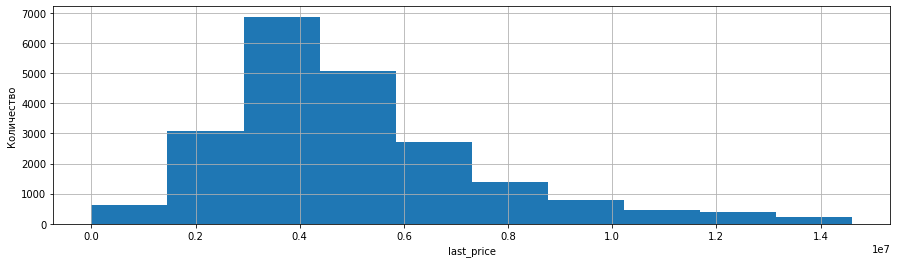

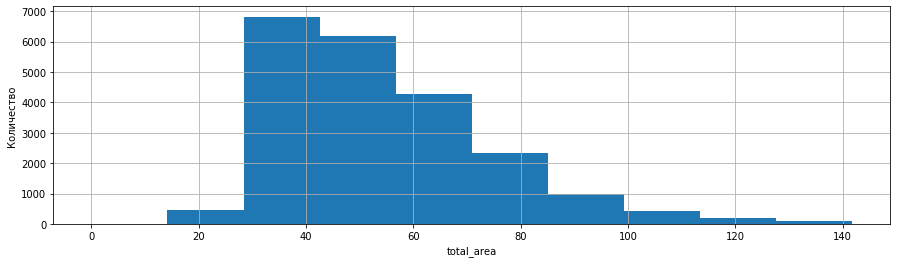

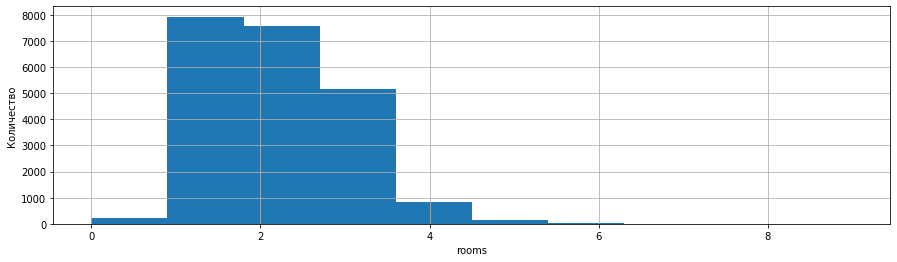

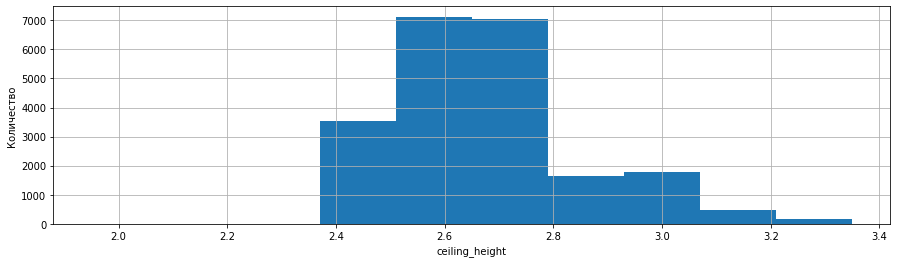

In [54]:
def filtered_hist(row):
    row_dsc = row.describe()
    max_range = row_dsc['75%'] +  3 * (row_dsc['75%'] - row_dsc['25%'])
    min_range = row_dsc['25%'] -  3 * (row_dsc['75%'] - row_dsc['25%'])
    min_range = 0 if min_range < 0 else min_range 
    plt.figure()
    plt.ylabel("Количество")
    plt.xlabel(row.name)
    return row.hist(range=(min_range, max_range), figsize=our_figsize, bins=10)

df[['last_price', 'total_area', 'rooms', 'ceiling_height']].apply(filtered_hist)
print(end='')

Диапазоны в которых находится большая часть значений: для площади это 160 квадратных метров, цена в основном не уходит за 14 миллионов, количество комнат ограничивается 6 и немного потолков выше 3,2 метров.

### Время продажи квартиры

В данных есть объявления которые не завершились продажей до времени выгрузки, учитывать их не будем.

In [20]:
data = df[~df['days_exposition'].isna()]

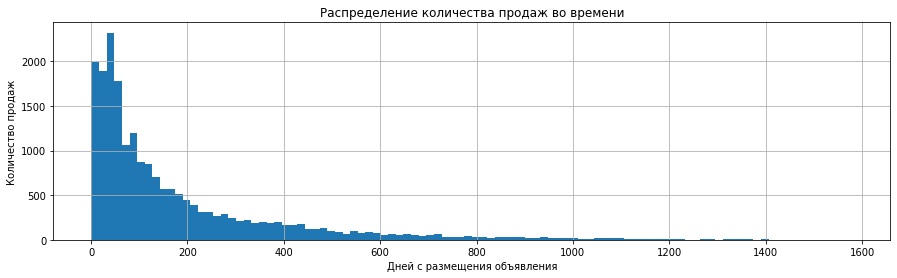

In [21]:
plt.figure(figsize=our_figsize)
plt.hist(data.days_exposition, bins=100)
plt.xlabel("Дней с размещения объявления")
plt.ylabel("Количество продаж")
plt.title("Распределение количества продаж во времени")
plt.grid(True)
plt.show()

In [22]:
data.days_exposition.describe()

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Треть всех продаж происходит в течении 232 дней. Проанализируем какие продажи можно считать быстрыми, а какие нет. Для наглядности возьмем период в 30 дней, примерно месяц. Посмотрим на распределение количества продаж по интервалам.

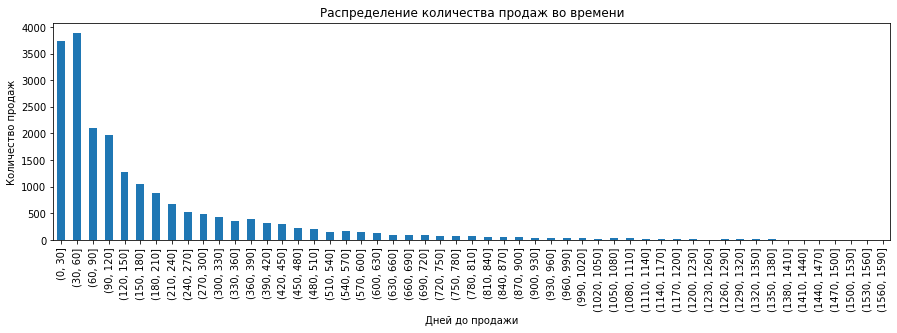

In [23]:
sell_interval = pd.interval_range(start=0, end=1590, freq=30) #создаем интервал для деления на группы

ax = (
    pd.cut(data.days_exposition, sell_interval) #делим данные на группы по продолжительности продажи
    .value_counts() #считаем количество продаж в каждой группе
    .reset_index()
    .sort_values(by='index') #сортируем по дням
    .plot(x='index', y='days_exposition', kind='bar', figsize=our_figsize, legend=False, 
          title='Распределение количества продаж во времени')
)
ax.set_xlabel("Дней до продажи")
ax.set_ylabel("Количество продаж")
print(end='')

На графике видно, что много продаж осуществляется в первые 60 дней - это зона быстрых продаж. От 150 дней - зона  долгих продаж.

### Редкие и выбивающиеся значения

Напишем функцию которая будет выдавать индексы строк со значениями который выходят за предел Q1 - 3IQR : Q3 + 3IQR. Далее удалим эти строки из данных и построим boxplot.

In [24]:
def out_of_range(df, row):
    row_dsc = df[row].describe()
    plt.figure()
    ax = df[row].plot(kind='box', vert=False, figsize=(15, 1), title='До обработки')
    plt.yticks(rotation=90, va='center')
    max_range = row_dsc['75%'] +  3 * (row_dsc['75%'] - row_dsc['25%'])
    min_range = row_dsc['25%'] -  3 * (row_dsc['75%'] - row_dsc['25%'])
    result = df[row].apply(lambda x: (x < min_range) or (x > max_range))
    df.drop(result[result == True].index, inplace=True)
    plt.figure()
    ax = df[row].plot(kind='box', vert=False, figsize=(15, 1), title='После обработки')
    plt.yticks(rotation=90, va='center')

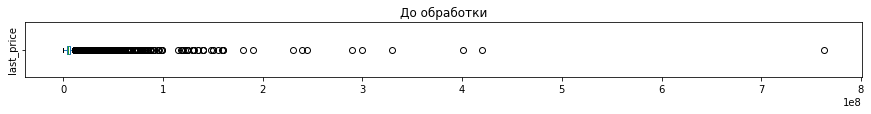

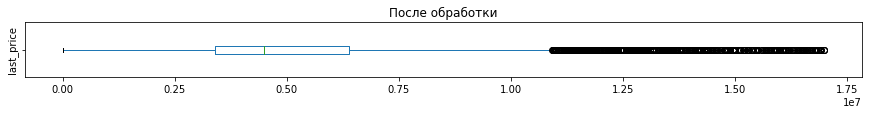

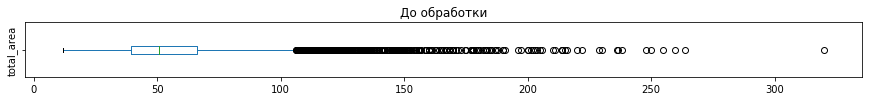

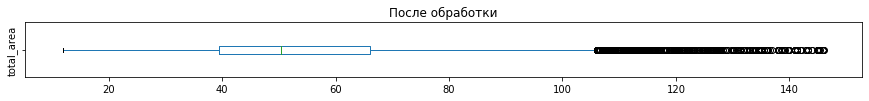

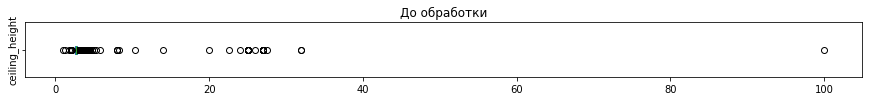

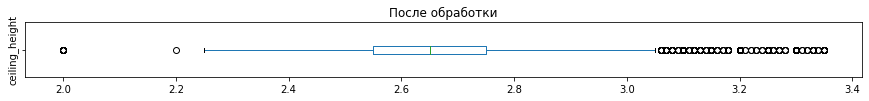

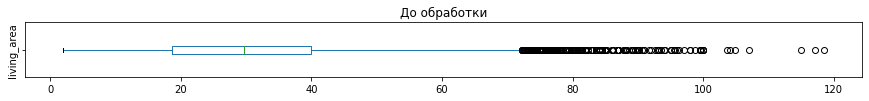

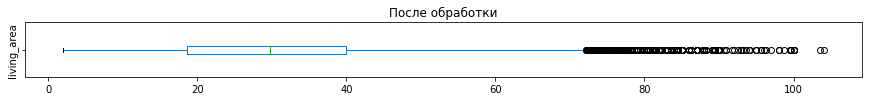

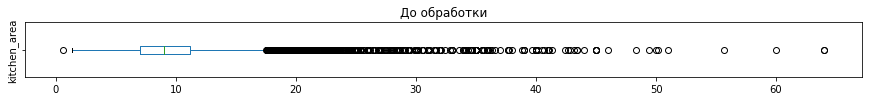

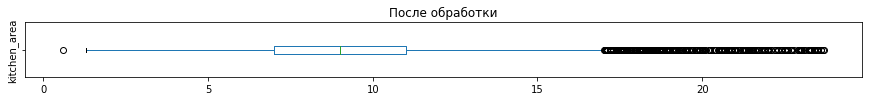

In [25]:
for i in ['last_price', 'total_area', 'ceiling_height', 'living_area', 'kitchen_area']:
    out_of_range(df, i)
print(end='')

Смущает наличие объявлений с количеством комнат равным 0. Возможно так обозначают студии. Посмотрим сколько таких объявлений.

In [26]:
df.query('rooms == 0')['rooms'].count()

193

Теперь посмотрим сколько объявлений обозначены как 'студия' и какое количество комнат содержат эти объявления.

In [27]:
df.query('studio == True').rooms.value_counts()

0    136
1     11
Name: rooms, dtype: int64

Одиннадцать объявлений с одной комнатой, их надо будет исправить. Но общее количество записей 148. А это значит ещё есть объявления с нулем комнат, но не отмеченные как студия. Поправим это.

In [28]:
df.loc[(df.studio == True) & (df.rooms == 1), 'rooms'] = 0
df.loc[(df.studio == False) & (df.rooms == 0), 'studio'] = True
all(df.query('studio == True').index == df.query('rooms == 0').index)

True

Исправили небольшой недочет в данных. Строк мало и вряд ли бы они могли существенно исказить данные по этим параметрам. Но раз нашли несоответсвие стоит его поправить.

### Что влияет на стоимость квартиры

Посмотрим как влияют факторы количества комнат, площади и удаленности от центра на цену квартиры.

In [29]:
df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'meter_price']].corr()

,last_price,total_area,rooms,cityCenters_nearest,meter_price
last_price,1.000000,0.739648,0.467641,-0.346258,0.649905
total_area,0.739648,1.000000,0.805323,-0.159304,0.019894
rooms,0.467641,0.805323,1.000000,-0.102580,-0.165143
cityCenters_nearest,-0.346258,-0.159304,-0.102580,1.000000,-0.402488
meter_price,0.649905,0.019894,-0.165143,-0.402488,1.000000


Цена лучше коррелирует с общей площадью и хуже с количеством комнат. А вот площадь имеет высокий коэффициент корреляции с количеством комнат, что вполне логично. Расстояние имеет отрицательную корреляцию с ценой. Что тоже логично, чем дальше от центра, тем дешевле.

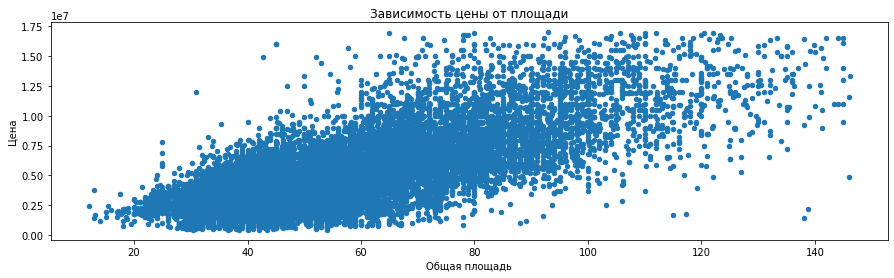

In [30]:
ax = df.plot(y='last_price', x='total_area', kind='scatter', figsize=our_figsize)
ax.set(ylabel='Цена', xlabel='Общая площадь', title='Зависимость цены от площади')
print(end='')

Ярковыраженная линейная заисимость. чем больше площадь тем больше цена.

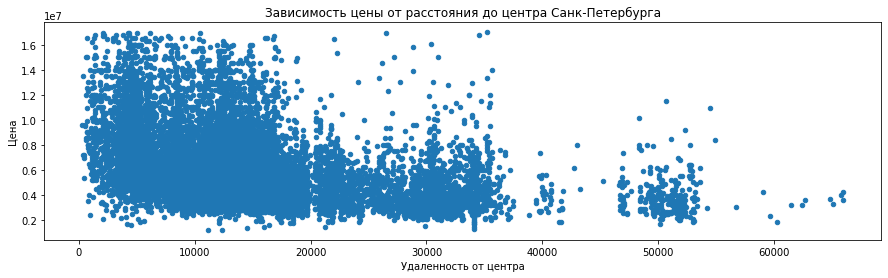

In [31]:
ax = df.plot(y='last_price', x='cityCenters_nearest', kind='scatter', figsize=our_figsize)
ax.set(ylabel='Цена', xlabel='Удаленность от центра', title='Зависимость цены от расстояния до центра Санк-Петербурга')
print(end='')

В диапазоне 20 километров от центра можно наблюдать большое количество предложений в любой ценовой категории. Но чем дальше тем количество дорогих квартир снижается. На расстоянии 60 км вообще не предложений выше 6 миллионов.

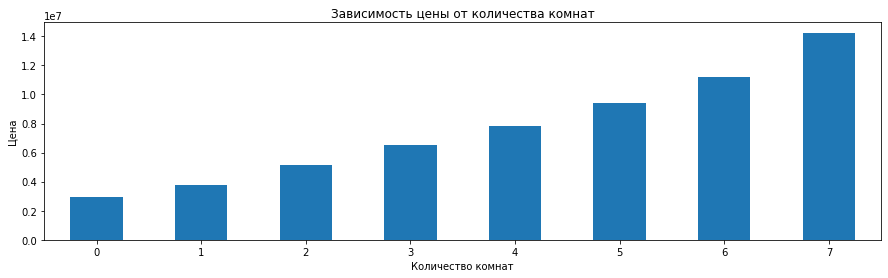

In [32]:
ax = df.groupby('rooms')['last_price'].agg('mean').plot(y='last_price', x='index', kind='bar', figsize=our_figsize)
ax.set(ylabel='Цена', xlabel='Количество комнат', title='Зависимость цены от количества комнат')
plt.xticks(rotation=0)
print(end='')

Как видно из таблицы количество комнат очень сильно коррелирует с общей площадью. Здесь на графике мы можем в этом убедиться. Цена имеет прямую зависимость от площади, а значит будет коррелировать и с количеством комнат.

### Влияние этажа на цену

Оценим влияет ли фактор первого или последнего этажа на цену за квадратный метр.

In [33]:
df.pivot_table(index='floor_type', values=['last_price', 'meter_price'], aggfunc='median')

,last_price,meter_price
floor_type,,
другой,4600000,96867.270
первый,3800000,80367.695
последний,4075000,85317.140


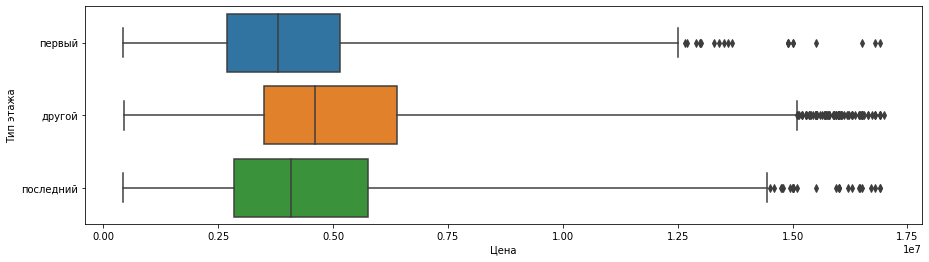

In [34]:
plt.figure(figsize=our_figsize)
ax = sns.boxplot(y='floor_type', x='last_price', data=df, orient='h', whis=3)
ax.set(xlabel='Цена', ylabel='Тип этажа')
print(end='')

Как видно из сводной таблицы первый этаж ценится меньше всего. И цена на последний этаж также меньше чем обычные квартиры.

### Анализ цены от дня, месяца и года

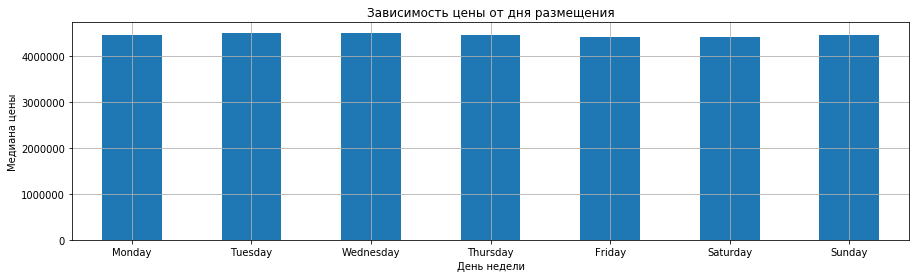

In [35]:
ax = (
    df
    .pivot_table(index='exposition_weekday', values='last_price', aggfunc='median')
    .rename(index={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})
    .reset_index()
    .plot(x='exposition_weekday', y='last_price', kind='bar', legend=False, figsize=our_figsize, grid=True)
)
ax.set_xlabel("День недели")
ax.set_ylabel("Медиана цены")
ax.set_title("Зависимость цены от дня размещения")
plt.xticks(rotation=0)
print(end='')

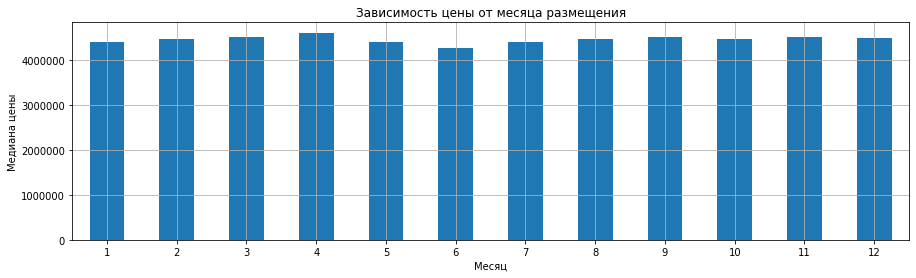

In [36]:
ax = (
    df
    .pivot_table(index='exposition_month', values='last_price', aggfunc='median')
    .reset_index()
    .sort_values(by='exposition_month')
    .plot(x='exposition_month', y='last_price', kind='bar', legend=False, figsize=our_figsize, grid=True)
)
ax.set_xlabel("Месяц")
ax.set_ylabel("Медиана цены")
ax.set_title("Зависимость цены от месяца размещения")
plt.xticks(rotation=0)
print(end='')

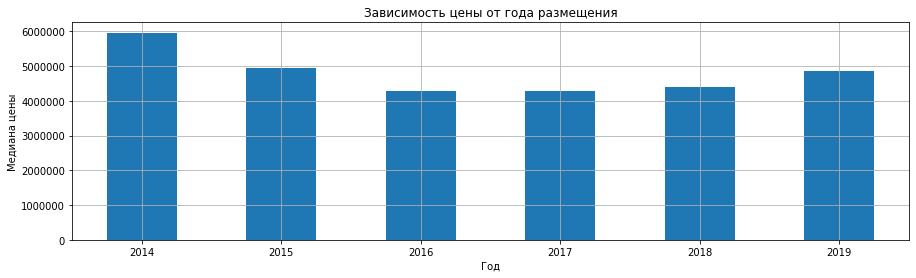

In [37]:
ax = (
    df
    .pivot_table(index='exposition_year', values='last_price', aggfunc='median')
    .reset_index()
    .sort_values(by='exposition_year')
    .plot(x='exposition_year', y='last_price', kind='bar', legend=False, figsize=our_figsize, grid=True)
)
ax.set_xlabel("Год")
ax.set_ylabel("Медиана цены")
ax.set_title("Зависимость цены от года размещения")
plt.xticks(rotation=0)
print(end='')

Как видно из гистограмм день размещения объявления не влияет на цену. Весной цены немного падают, но начиная с июля начинают повышаться. А вот из графиков по годам видно как упали цены в 2015 году, в период кризиса, и до 2019 так и не смогли выйти на докризисный уровень.

### Анализ по населенным пунктам

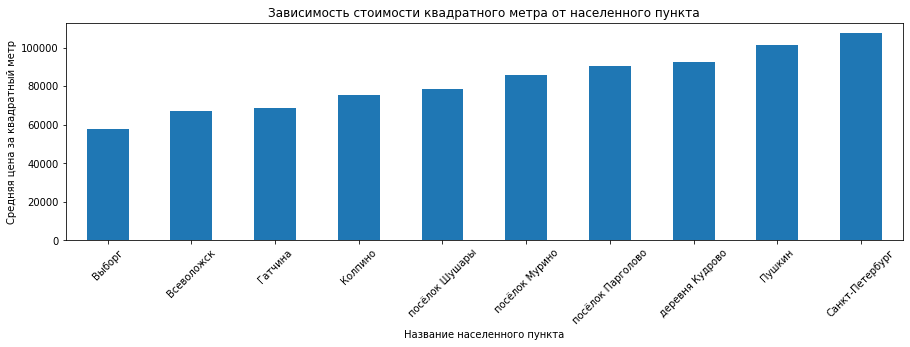

In [38]:
ax = (
    df
    .pivot_table(index='locality_name', values='meter_price', aggfunc=['count', 'mean'])
    .sort_values(by=('count', 'meter_price'), ascending=False)
    .head(10)
    .reset_index()
    .sort_values(by=('mean', 'meter_price'))
    .plot(x='locality_name', y=('mean', 'meter_price'), kind='bar', legend=False, figsize=our_figsize)
)
ax.set_xlabel("Название населенного пункта")
ax.set_ylabel("Средняя цена за квадратный метр")
ax.set_title("Зависимость стоимости квадратного метра от населенного пункта")
plt.xticks(rotation=45)
print(end='')

Самое дешевое жилье в Выборге. Ожидаемо самое дорогое в Санкт-Петербурге.

### Цены на жилье в Санкт-Петербурге

Создадим новую колонку с расстоянием до центра города в километрах.

In [39]:
data = df.query('locality_name == "Санкт-Петербург"') 
data.loc[:,'km_to_center'] = round(data.loc[:,'cityCenters_nearest'] / 1000)

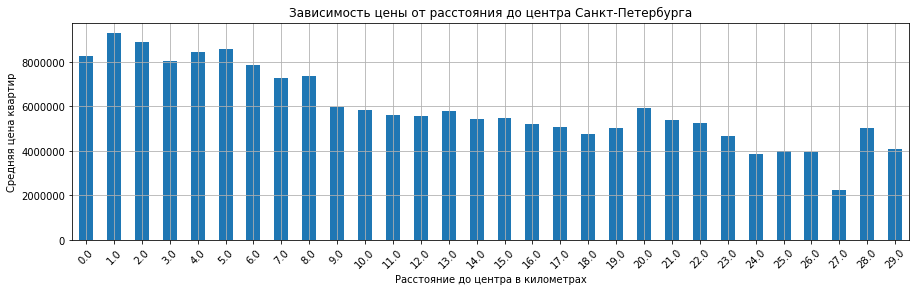

In [40]:
ax = (
    data
    .pivot_table(index='km_to_center', values='last_price', aggfunc='mean')
    .reset_index()
    .sort_values(by='km_to_center')
    .plot(x='km_to_center', y='last_price', kind='bar', figsize=our_figsize, grid=True, legend=False)
)
ax.set_xlabel("Расстояние до центра в километрах")
ax.set_ylabel("Средняя цена квартир")
ax.set_title("Зависимость цены от расстояния до центра Санкт-Петербурга")
plt.xticks(rotation=45)
print(end='')

На основание этого графика будем считать квартиры удаленные от центра менее чем на 8 километров, находящимися в центральнои районе.

In [41]:
city_center = (
    data
    .loc[(data['km_to_center'] < 8), 
         ['last_price', 'total_area', 'rooms', 'ceiling_height', 'km_to_center', 'floor', 'exposition_year', 'meter_price']]
)
city_downtown = (
    data
    .loc[(data['km_to_center'] >= 8), 
         ['last_price', 'total_area', 'rooms', 'ceiling_height', 'km_to_center', 'floor', 'exposition_year', 'meter_price']]
)

In [42]:
def percent_hist(row1, row2, bins=5):
    r1_weights = np.ones(len(row1)) / len(row1)
    r2_weights = np.ones(len(row2)) / len(row2)
    plt.figure(figsize=our_figsize)
    plt.xlabel(row1.name)
    plt.ylabel("Количество в процентах")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.hist(row1, weights=r1_weights, alpha=0.5, bins=bins)
    plt.hist(row2, weights=r2_weights, alpha=0.5, bins=bins)
    plt.legend(labels=('Центральные районы', 'Другие районы'))
    plt.grid(True)
    plt.show()

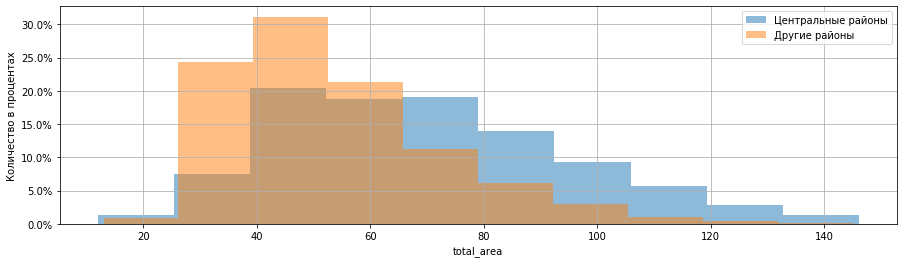

In [43]:
percent_hist(city_center.total_area, city_downtown.total_area, bins=10)

По графикам видно, что в центре больше всего квартир в диапазоне 60-100 квадратных метров, когда как в других районах преобладает диапазон 40-60 квадратных метров.

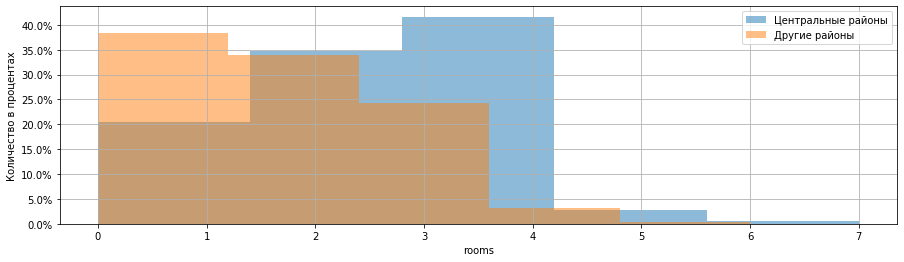

In [44]:
percent_hist(city_center.rooms, city_downtown.rooms)

Ранее мы считали корреляцию между площадью и количеством комнат, она было достаточно высока ~0.79. Графиками выше мы это ещё раз подтвердили. Т.к. в центре располагаются квартиры с большим метражом, в которых и комнат оказалось больше. 

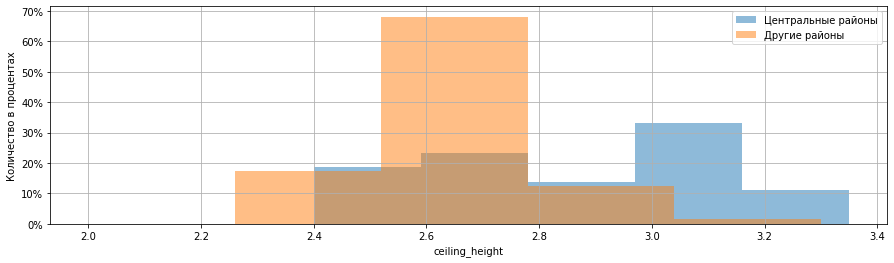

In [45]:
percent_hist(city_center.ceiling_height, city_downtown.ceiling_height)

С потолками аналогичная ситуация. По всем показателям в центре более элитное жилье, что вполне логично. Очевидно, что и средняя цена будет существенно различаться.

In [46]:
round(city_center.last_price.mean() - city_downtown.last_price.mean())

2685441

Целых 2.7 миллиона. Серьезные деньги. Теперь хотелось бы узнать одинаково ли повлиял кризис на цены. Напишем функцию для сравнения одинаковых параметров из двух датафреймов.

In [47]:
def compare_plot(df1=None, df2=None, index1=None, val1=None, index2=None, val2=None, width=0.2, xlabel=None, ylabel=None,
                title=None, legend1=None, legend2=None, loc='upper right'):
    ax = (
    df1
    .pivot_table(index=index1, values=val1, aggfunc='median')
    .reset_index()
    .sort_values(by=index1)
    .plot(x=index1, y=val1, kind='bar', legend=True, figsize=our_figsize,
         position=0, width=width)
    )    
    (
    df2
    .pivot_table(index=index2, values=val2, aggfunc='median')
    .reset_index()
    .sort_values(by=index2)
    .plot(x=index2, y=val2, kind='bar', legend=True, figsize=our_figsize, color='#DC7633', ax=ax,
         position=1, width=width)
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=0)
    ax.legend([legend1, legend2], loc=loc)

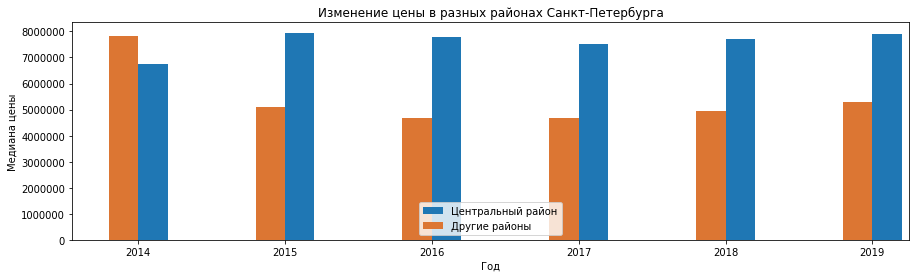

In [48]:
compare_plot(df1=city_center, index1='exposition_year', val1='last_price',
             df2=city_downtown, index2='exposition_year', val2='last_price',
             xlabel='Год', ylabel='Медиана цены', title='Изменение цены в разных районах Санкт-Петербурга',
             legend1='Центральный район', legend2='Другие районы', loc='lower center')

Кризис серьезно ударил по более дешевому жилью на окраинах. Сегмент элитного жилья практически незыблем.
Оценим какие факторы вносят наибольший вклад в цену жилья в центре города.

In [49]:
city_center[['last_price', 'total_area', 'rooms', 'ceiling_height', 'km_to_center', 'floor', 'meter_price']].corr()

,last_price,total_area,rooms,ceiling_height,km_to_center,floor,meter_price
last_price,1.000000,0.703217,0.455028,0.138497,-0.132186,0.126492,0.381758
total_area,0.703217,1.000000,0.809128,0.226038,-0.190827,-0.018677,-0.339938
rooms,0.455028,0.809128,1.000000,0.205305,-0.197659,-0.122173,-0.427865
ceiling_height,0.138497,0.226038,0.205305,1.000000,-0.223883,-0.185344,-0.088008
km_to_center,-0.132186,-0.190827,-0.197659,-0.223883,1.000000,0.230696,0.043133
floor,0.126492,-0.018677,-0.122173,-0.185344,0.230696,1.000000,0.192520
meter_price,0.381758,-0.339938,-0.427865,-0.088008,0.043133,0.192520,1.000000


Наибольший вклад в цену вносит площадь. Но коэффициент корреляции немного меньше чем для всех данных.

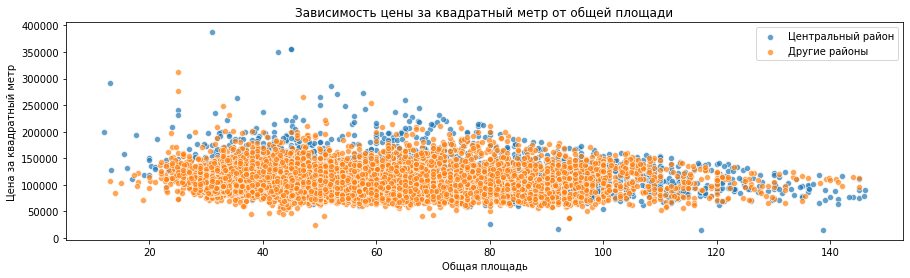

In [50]:
plt.subplots(figsize=our_figsize)
ax = sns.scatterplot(data=city_center, x='total_area', y='meter_price', alpha=0.7)
sns.scatterplot(data=city_downtown, x='total_area', y='meter_price', alpha=0.7, ax=ax)
ax.set(xlabel='Общая площадь', ylabel='Цена за квадратный метр',
      title='Зависимость цены за квадратный метр от общей площади')
ax.legend(['Центральный район', 'Другие районы'], loc='upper right')
print(end='')

Основная часть значений пересекатеся друг с другом. Но график для центрального района немного повыше, значит в среднем цена за квадратный метр в центре больше. И на больших площадях практически не встречается квартир из других районов. В центре квартиры с большой площадью встречаются чаще.

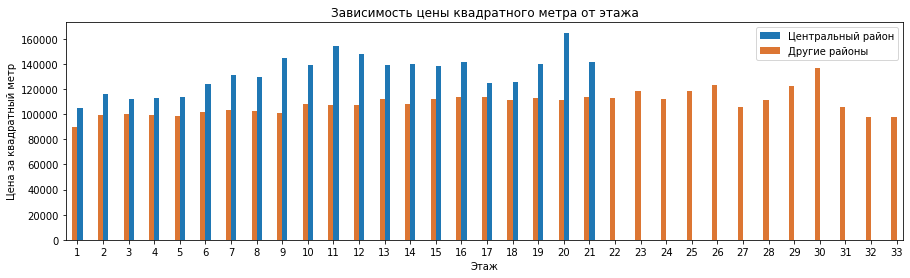

In [51]:
compare_plot(df1=city_center, index1='floor', val1='meter_price',
             df2=city_downtown, index2='floor', val2='meter_price',
             xlabel='Этаж', ylabel='Цена за квадратный метр', title='Зависимость цены квадратного метра от этажа',
             legend1='Центральный район', legend2='Другие районы')

Как видно из графика в центре не найти здания выше 21 этажа. Средняя цена за квадратный метр в высоких домах оказалась больше. Возможно это связано с видовыми квартирами, которые могут существено повысить цену.

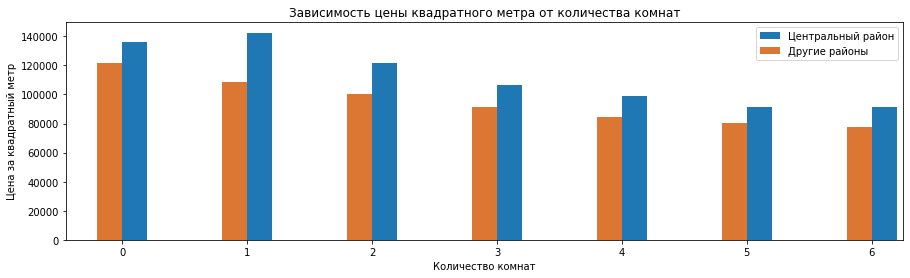

In [52]:
compare_plot(df1=city_center, index1='rooms', val1='meter_price',
             df2=city_downtown, index2='rooms', val2='meter_price',
             xlabel='Количество комнат', ylabel='Цена за квадратный метр', 
             title='Зависимость цены квадратного метра от количества комнат',
             legend1='Центральный район', legend2='Другие районы')

Больше всего ценятся одно- и двухкомнатные квартиры. Не стал бы включать студии ввиду их малого количества относительно всех объявлений (см. пункт "Редкие и выбивающиеся значения). В центре преобладают двухкомнатные и трехкомнатные квартиры. Этим также можно объяснить такую высокую ценность однокомнатных (редкие). И из-за близости к центру и малого метража цена за квадратный метр становится очень большая.

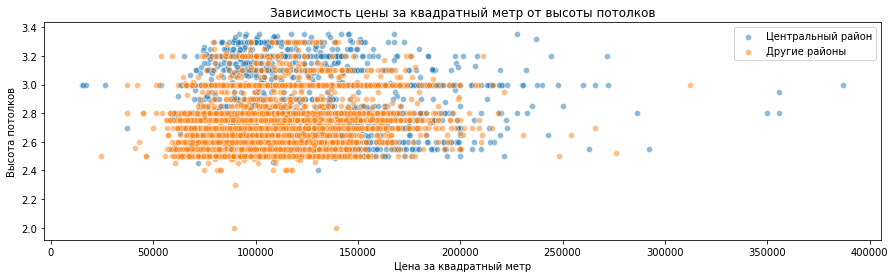

In [53]:
plt.subplots(figsize=our_figsize)
ax = sns.scatterplot(data=city_center, y='ceiling_height', x='meter_price', alpha=0.5)
sns.scatterplot(data=city_downtown, y='ceiling_height', x='meter_price', alpha=0.5, ax=ax)
ax.set(xlabel='Цена за квадратный метр', ylabel='Высота потолков', 
       title='Зависимость цены за квадратный метр от высоты потолков')
ax.legend(['Центральный район', 'Другие районы'], loc='upper right')
print(end='')

Среди обычных районов практически не встречаются высокие квартиры. В основной массе цены находятся в одном диапазоне. Я бы сказал, что корреляция здесь слабая.
Объеденяя все данные можем сказать, что в центре высокие и просторные квартиры. Этаж очень сильно влияет на цену для центральных районов, для остальных колебания происходят в районе 25 этажа. Чем больше комнат, там медиана цены за квадратный метр становится меньше. Это справедливо для всех квартир (оптом дешевле).

### Шаг 5. Общий вывод

После анализа данных можем с уверенностью утверждать следующее:
- есть две характеристики которые вносят наибольший вклад в цену: общая площадь (прямая корреляция) и расстояние до центра (обратная корреляция)
- квартиры первого этажа ценяться меньше, чем квартиры последнего, которые в свою очередь дешевле средних этажей
- цены упали в кризис 2015 года, и до 2019 так и не вышли на докризисный уровень
- просадки цены в центральном районе Санкт-Петербурга практически не было
- самым дорогим пригородом Санкт-Петербурга являются Пушкин и Кудрово, а самым дешевым - Выборг
- квартиры в центральном районе имеют большую площадь, количество комнат и высоту потолков. Это и их местоположение увеличивает цену в среднем на 2,7 миллиона.
- если квартира не продалась за 150 дней, стоит подумать о снижении цены